# The Graph of Sententially Co-Occurrent 2-Grams in Books

## Moses Boudourides

In [1]:
import pandas as pd
import numpy as np
import random
# import urllib.request
import urllib2 
import re, string, math
import nltk
nltk.download('punkt')
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer #, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from collections import Counter
import itertools
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mosesboudourides/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load data

In [2]:
url = "https://www.gutenberg.org/files/16/16-0.txt" # peter pan from the gutenberg project
request = urllib2.Request(url)
response = urllib2.urlopen(request)
peter_pan = response.read().decode('utf-8')
titlename="Peter Pan"

### Trim preface and epilogue and split in Chapters

In [3]:
peter_pan = peter_pan[0:263923]
print(len(peter_pan))

263923


In [4]:
chapters = peter_pan[0:1466]
chapters = chapters[917:1466]
print(len(chapters))

549


In [5]:
chapter_ls = [x.strip() for x in chapters.split('\r\n') if x.strip()]
chapter_ls[7] = "Chapter 8 THE MERMAIDS' LAGOON"
print(len(chapter_ls))

17


In [6]:
for c in chapter_ls:
    print(c)

Chapter 1 PETER BREAKS THROUGH
Chapter 2 THE SHADOW
Chapter 3 COME AWAY, COME AWAY!
Chapter 4 THE FLIGHT
Chapter 5 THE ISLAND COME TRUE
Chapter 6 THE LITTLE HOUSE
Chapter 7 THE HOME UNDER THE GROUND
Chapter 8 THE MERMAIDS' LAGOON
Chapter 9 THE NEVER BIRD
Chapter 10 THE HAPPY HOME
Chapter 11 WENDY'S STORY
Chapter 12 THE CHILDREN ARE CARRIED OFF
Chapter 13 DO YOU BELIEVE IN FAIRIES?
Chapter 14 THE PIRATE SHIP
Chapter 15 “HOOK OR ME THIS TIME”
Chapter 16 THE RETURN HOME
Chapter 17 WHEN WENDY GREW UP


In [7]:
peter_pan = peter_pan[0:263923]  # trim epilogue
peter_pan = peter_pan[1476:len(peter_pan)] # trim prefave
peter_pan

u"Chapter 1 PETER BREAKS THROUGH\r\n\r\nAll children, except one, grow up. They soon know that they will grow\r\nup, and the way Wendy knew was this. One day when she was two years old\r\nshe was playing in a garden, and she plucked another flower and ran with\r\nit to her mother. I suppose she must have looked rather delightful, for\r\nMrs. Darling put her hand to her heart and cried, \u201cOh, why can't you\r\nremain like this for ever!\u201d This was all that passed between them on\r\nthe subject, but henceforth Wendy knew that she must grow up. You always\r\nknow after you are two. Two is the beginning of the end.\r\n\r\nOf course they lived at 14 [their house number on their street], and\r\nuntil Wendy came her mother was the chief one. She was a lovely lady,\r\nwith a romantic mind and such a sweet mocking mouth. Her romantic\r\nmind was like the tiny boxes, one within the other, that come from the\r\npuzzling East, however many you discover there is always one more; and\r\nher s

In [8]:
peter_pan_ls = peter_pan.split('\r\n\r\n')
peter_pan_df = pd.DataFrame(peter_pan_ls, columns = ['text'])
peter_pan_df.text = peter_pan_df.text.str.strip() # get rid of whitespace
print(peter_pan_df.shape)
peter_pan_df.head()

(1686, 1)


,text
0,Chapter 1 PETER BREAKS THROUGH
1,"All children, except one, grow up. They soon k..."
2,Of course they lived at 14 [their house number...
3,The way Mr. Darling won her was this: the many...
4,Mr. Darling used to boast to Wendy that her mo...


In [9]:
# peter_pan_df['chapter_index'] = peter_pan_df.text.apply(lambda x: chapter_ls.index(x)+1 if x in chapter_ls else 0)
peter_pan_df['chapter_index'] = peter_pan_df.text.apply(lambda x: 1 if x in chapter_ls else 0)
peter_pan_df['chapter'] = np.cumsum(peter_pan_df.chapter_index)
print(peter_pan_df.shape)
peter_pan_df.loc[peter_pan_df.chapter_index != 0,:]

(1686, 3)


,text,chapter_index,chapter
0,Chapter 1 PETER BREAKS THROUGH,1,1
54,Chapter 2 THE SHADOW,1,2
160,"Chapter 3 COME AWAY, COME AWAY!",1,3
353,Chapter 4 THE FLIGHT,1,4
485,Chapter 5 THE ISLAND COME TRUE,1,5
574,Chapter 6 THE LITTLE HOUSE,1,6
711,Chapter 7 THE HOME UNDER THE GROUND,1,7
734,Chapter 8 THE MERMAIDS' LAGOON,1,8
899,Chapter 9 THE NEVER BIRD,1,9
925,Chapter 10 THE HAPPY HOME,1,10


In [10]:
peter_pan_filtered = peter_pan_df.loc[peter_pan_df.chapter_index == 0,:]
# peter_pan_filtered.text = peter_pan_filtered.text.apply(lambda x: re.sub(r'[^\w\s]','',x)) # filter out punctuation
peter_pan_filtered.text = peter_pan_filtered.text.apply(lambda x: re.sub('\r|\n',' ',x)) # filter out indentation spaces
peter_pan_filtered.text = peter_pan_filtered.text.apply(lambda x: x.lower()) # strip whitespace
peter_pan_filtered = peter_pan_filtered[['text','chapter']]
print (peter_pan_filtered.shape)
peter_pan_filtered.head()

(1669, 2)


/Users/mosesboudourides/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,text,chapter
1,"all children, except one, grow up. they soon k...",1
2,of course they lived at 14 [their house number...,1
3,the way mr. darling won her was this: the many...,1
4,mr. darling used to boast to wendy that her mo...,1
5,"mrs. darling was married in white, and at firs...",1


In [11]:
peter_pan_chapter_str = peter_pan_filtered.groupby(['chapter'])['text'].apply(' '.join).reset_index()
peter_pan_chapter_str.text = peter_pan_chapter_str.text.str.strip() # get rid of whitespace
peter_pan_chapter_str['str_length'] = peter_pan_chapter_str.text.apply(len)
print (peter_pan_chapter_str.shape)
df=peter_pan_chapter_str
df

(17, 3)


,chapter,text,str_length
0,1,"all children, except one, grow up. they soon k...",16585
1,2,"mrs. darling screamed, and, as if in answer to...",15963
2,3,for a moment after mr. and mrs. darling left t...,22527
3,4,"“second to the right, and straight on till mor...",15523
4,5,"feeling that peter was on his way back, the ne...",19795
5,6,foolish tootles was standing like a conqueror ...,13734
6,7,one of the first things peter did next day was...,13015
7,8,"if you shut your eyes and are a lucky one, you...",20976
8,9,the last sound peter heard before he was quite...,5882
9,10,one important result of the brush [with the pi...,10828


In [12]:
text=[]
for i in range(len(df)):
    text.append(df.iloc[i]["text"])
print(len(text))
# text[3]

17


In [13]:
# 2-grams vectorization of text
vectorizer = TfidfVectorizer(stop_words = 'english', ngram_range=(2,2))  #(1,2)
X = vectorizer.fit_transform(text)
words = vectorizer.get_feature_names()
# print("words", len(words),words) 

In [14]:
n_clusters=10 #len(text)
number_of_terms=300
number_of_seeds_to_try=10
max_iter = 500
number_of_process=2 # seads are distributed
model = KMeans(n_clusters=n_clusters, max_iter=max_iter, n_init=number_of_seeds_to_try, n_jobs=number_of_process).fit(X)

labels = model.labels_
# indices of preferible words in each cluster
ordered_words = model.cluster_centers_.argsort()[:, ::-1]

# # print("centers:", model.cluster_centers_)
# # print("labels", labels)
# # print("intertia:", model.inertia_)

centers=model.cluster_centers_

text_per_cluster = np.zeros(n_clusters)
for i_cluster in range(n_clusters):
    for label in labels:
        if label==i_cluster:
            text_per_cluster[i_cluster] +=1 

top_2grams=[]
# print("Top words per cluster:")
for i_cluster in range(n_clusters):
#     print("Cluster:", i_cluster, "text:", int(text_per_cluster[i_cluster])),
    for term in ordered_words[i_cluster, :number_of_terms]: 
#         print("\t"+words[term])
        if term not in top_2grams:
            top_2grams.append(words[term])

top_2grams=[t for t in top_2grams if len(t)>2]            
top_2grams=sorted(set(top_2grams))
top_2grams=[str(w) for w in top_2grams]
print("top 2grams",len(top_2grams))
top_2grams

/Users/mosesboudourides/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:30: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


('top 2grams', 2908)


['absolutely finished',
 'adventure hours',
 'adventures tell',
 'ago mark',
 'ah old',
 'answer rang',
 'answered braves',
 'answered cheer',
 'answered don',
 'appealing outstretched',
 'appearance beating',
 'appearance pirates',
 'appears visited',
 'arm crocodile',
 'arms exclaim',
 'arms extended',
 'arms fall',
 'arms followed',
 'arms little',
 'arms peter',
 'arms slings',
 'arose passed',
 'arrange line',
 'arrangements wish',
 'arrow dared',
 'arrows pointing',
 'artifice save',
 'ascend drew',
 'ashore presently',
 'ashore tired',
 'asked hook',
 'asked lost',
 'asked michael',
 'asked middle',
 'asked pass',
 'asked redskins',
 'asleep peter',
 'asleep says',
 'ass cried',
 'attempt help',
 'attempted mother',
 'authentic charming',
 'available tree',
 'avast belay',
 'average hour',
 'await onslaught',
 'awaiting big',
 'awaiting cold',
 'awake asleep',
 'awake exquisite',
 'away door',
 'away hear',
 'away little',
 'away mr',
 'away mrs',
 'away oo',
 'away raging',
 'a

In [15]:
occurdic={}
for np in top_2grams:
    s=0
    for t in text:
        s+=t.count(np)
    occurdic[np]=s

df = pd.DataFrame(columns=["%s 2-gram" %titlename, "Frequency"])
u=1
for l,v in occurdic.items(): 
    df.loc[u]=[l,v]
    u+=1

print "The total number of 2-grams in %s is %i." %(titlename,len(df))#len(npA))
df.sort_values(["Frequency"], ascending=[0])

cut = 1
df = df[df['Frequency']>cut].sort_values(["Frequency"], ascending=[0])
print "The total number of 2-grams in %s with frequencies > %i is %i." %(titlename,cut,len(df))#len(npA))
df.sort_values(["Frequency"], ascending=[0])

The total number of 2-grams in Peter Pan is 2908.
The total number of 2-grams in Peter Pan with frequencies > 1 is 179.


,Peter Pan 2-gram,Frequency
605,tinker bell,29
792,said peter,20
2712,wendy said,19
364,peter pan,18
2431,oh dear,15
268,peter said,13
1819,tiger lily,12
2607,john said,11
189,little house,11
2791,good form,10


## Sentences

In [16]:
textSentences=[]
for t in text:
    blob = TextBlob(t)
    ts = blob.sentences
    textSentences.append(ts)
textSentences = [item for sublist in textSentences for item in sublist]
print(len(textSentences))
textSentences

2316


[Sentence("all children, except one, grow up."),
 Sentence("they soon know that they will grow  up, and the way wendy knew was this."),
 Sentence("one day when she was two years old  she was playing in a garden, and she plucked another flower and ran with  it to her mother."),
 Sentence("i suppose she must have looked rather delightful, for  mrs. darling put her hand to her heart and cried, “oh, why can't you  remain like this for ever!” this was all that passed between them on  the subject, but henceforth wendy knew that she must grow up."),
 Sentence("you always  know after you are two."),
 Sentence("two is the beginning of the end."),
 Sentence("of course they lived at 14 [their house number on their street], and  until wendy came her mother was the chief one."),
 Sentence("she was a lovely lady,  with a romantic mind and such a sweet mocking mouth."),
 Sentence("her romantic  mind was like the tiny boxes, one within the other, that come from the  puzzling east, however many you dis

In [17]:
sendic=dict()
for i,v in enumerate(textSentences):
    sent=v.sentiment.polarity
    wl=[]
    for term in top_2grams:
        if term in v: #.split(): #dd['stripped'].split():
            wl.append(term)
    if len(wl)>1:
        sendic[i]=wl #ww1
sendic

{1: ['way wendy', 'wendy knew'],
 7: ['mocking mouth', 'romantic mind', 'sweet mocking'],
 8: ['hand corner', 'mocking mouth', 'sweet mocking'],
 78: ['darling did', 'peter pan'],
 88: ['children went', 'nursery floor', 'wendy said'],
 96: ['mother cried', 'said wendy'],
 100: ['darling examined', 'skeleton leaves'],
 131: ['darling examined', 'sure mrs'],
 159: ['john said', 'michael came'],
 232: ['hugged nana', 'wendy hugged'],
 268: ['called tinker', 'tinker bell'],
 287: ['moira angela', 'wendy moira'],
 291: ['moira angela', 'said wendy', 'wendy moira'],
 294: ['funny address', 'said peter'],
 297: ['said nicely', 'wendy said'],
 341: ['kensington gardens', 'long time', 'ran away'],
 353: ['fairy language', 'said wendy'],
 360: ['moment wendy', 'wendy saw'],
 362: ['said peter', 'tinker bell'],
 366: ['silly ass', 'tink replied'],
 367: ['called tinker', 'peter explained', 'tinker bell'],
 368: ['kensington gardens', 'lost boys'],
 383: ['nursery window', 'silly ass', 'tink repli

In [18]:
medges=[]
for k,v in sendic.items():
    sent=textSentences[k].sentiment.polarity
    dd={}
    ps=set()
    for j in itertools.combinations(v, 2):
        ps.add(j)
        dd[j]=(k,sent)
    for jj in ps:
        s=0
        ss=0
        for kk,vv in dd.items():
            if kk==jj:
                s+=1
                ss+=vv[1]
        medges.append((jj[0],jj[1],"Sentence_"+str(k),ss/float(s)))
print len(medges),len(set(medges))  
medges

449 449


[('small remnant', 'tiger lily', 'Sentence_1536', -0.4166666666666667),
 ('way wendy', 'wendy knew', 'Sentence_1', 0.0),
 ('ground till', 'rising ground', 'Sentence_1538', 0.2333333333333333),
 ('romantic mind', 'sweet mocking', 'Sentence_7', 0.2125),
 ('mocking mouth', 'sweet mocking', 'Sentence_7', 0.2125),
 ('mocking mouth', 'romantic mind', 'Sentence_7', 0.2125),
 ('hand corner', 'mocking mouth', 'Sentence_8', 0.3178571428571429),
 ('hand corner', 'sweet mocking', 'Sentence_8', 0.3178571428571429),
 ('mocking mouth', 'sweet mocking', 'Sentence_8', 0.3178571428571429),
 ('charming girls', 'thursday week', 'Sentence_2061', 0.4666666666666666),
 ('outstretched arms', 'stretched arms', 'Sentence_1559', 0.375),
 ('arms fall', 'outstretched arms', 'Sentence_1559', 0.375),
 ('arms fall', 'stretched arms', 'Sentence_1559', 0.375),
 ('dreadful wickedness', 'hook signed', 'Sentence_1565', -0.65),
 ('cleaning time', 'jane said', 'Sentence_2309', 0.1),
 ('cleaning time', 'spring cleaning', 'Se

In [19]:
medgesd=[]
for e in medges:
    d={}
#     d['Sentence']=e[2]
    d['Average sentiment']=e[3]
    medgesd.append((e[0],e[1],d))
for e in medgesd:
    print e

('small remnant', 'tiger lily', {'Average sentiment': -0.4166666666666667})
('way wendy', 'wendy knew', {'Average sentiment': 0.0})
('ground till', 'rising ground', {'Average sentiment': 0.2333333333333333})
('romantic mind', 'sweet mocking', {'Average sentiment': 0.2125})
('mocking mouth', 'sweet mocking', {'Average sentiment': 0.2125})
('mocking mouth', 'romantic mind', {'Average sentiment': 0.2125})
('hand corner', 'mocking mouth', {'Average sentiment': 0.3178571428571429})
('hand corner', 'sweet mocking', {'Average sentiment': 0.3178571428571429})
('mocking mouth', 'sweet mocking', {'Average sentiment': 0.3178571428571429})
('charming girls', 'thursday week', {'Average sentiment': 0.4666666666666666})
('outstretched arms', 'stretched arms', {'Average sentiment': 0.375})
('arms fall', 'outstretched arms', {'Average sentiment': 0.375})
('arms fall', 'stretched arms', {'Average sentiment': 0.375})
('dreadful wickedness', 'hook signed', {'Average sentiment': -0.65})
('cleaning time', '

In [20]:
G = nx.MultiGraph()
G.add_edges_from(medgesd)
for e in G.edges(data=True):
    if e[0]==e[1]:
        G.remove_edge(e[0],e[1])
print len(G.nodes()),len(G.edges())
for e in G.edges(data=True):
    print e

374 449
('wendy told', 'taken place', {'Average sentiment': 0.4666666666666666})
('resist raising', 'looking viciously', {'Average sentiment': -1.0})
('resist raising', 'man aboard', {'Average sentiment': -1.0})
('arms fall', 'outstretched arms', {'Average sentiment': 0.375})
('arms fall', 'stretched arms', {'Average sentiment': 0.375})
('waters rose', 'rose till', {'Average sentiment': 0.19166666666666665})
('waters rose', 'final gulp', {'Average sentiment': 0.19166666666666665})
('finest effort', 'wendy said', {'Average sentiment': 0.18571428571428572})
('finest effort', 'said complacently', {'Average sentiment': 0.18571428571428572})
('finest effort', 'stayed away', {'Average sentiment': 0.18571428571428572})
('finest effort', 'said wendy', {'Average sentiment': 0.18571428571428572})
('finest effort', 'window open', {'Average sentiment': 0.18571428571428572})
('hook fell', 'wendy snatched', {'Average sentiment': -0.14722222222222223})
('hook fell', 'pirates cooked', {'Average sentim

In [21]:
df = nx.to_pandas_edgelist(G) 
# df
df.rename(columns={'source':'First 2-gram term','target':'Second 2-gram term'}, inplace=True)
df=df[['First 2-gram term','Second 2-gram term','Average sentiment']]
df

,First 2-gram term,Second 2-gram term,Average sentiment
0,wendy told,taken place,0.466667
1,resist raising,looking viciously,-1.000000
2,resist raising,man aboard,-1.000000
3,arms fall,outstretched arms,0.375000
4,arms fall,stretched arms,0.375000
5,waters rose,rose till,0.191667
6,waters rose,final gulp,0.191667
7,finest effort,wendy said,0.185714
8,finest effort,said complacently,0.185714
9,finest effort,stayed away,0.185714


In [22]:
weight={(x,y):v['Average sentiment'] for x,y,v in G.edges(data=True)}
w_edges=[(x,y,z) for (x,y),z in weight.items()]
Gw = nx.Graph()
Gw.add_weighted_edges_from(w_edges)

In [23]:
print "Graph Gw is a weighted graph with %i nodes and %i edges" %(len(Gw.nodes()),len(Gw.edges()))
print "The density of Gw is %.3f" %nx.density(Gw)
if nx.is_connected(Gw)==True:
    print "Gw is a connected graph"
else:
    print "Gw is a disconnected graph and it has",nx.number_connected_components(Gw),"connected components"    
giant = max(nx.connected_component_subgraphs(Gw), key=len)
Gwlcc=Gw.subgraph(giant)
print "The largest connected component of Gw is a weighted graph with %i nodes and %i edges" %(len(Gwlcc.nodes()),len(Gwlcc.edges()))
print "The density of the largest connected component of Gw is %.3f" %nx.density(Gwlcc)

Graph Gw is a weighted graph with 374 nodes and 438 edges
The density of Gw is 0.006
Gw is a disconnected graph and it has 84 connected components
The largest connected component of Gw is a weighted graph with 161 nodes and 263 edges
The density of the largest connected component of Gw is 0.020


In [24]:
for e in Gw.edges(data=True):
    print e

('wendy told', 'taken place', {'weight': 0.4666666666666666})
('resist raising', 'looking viciously', {'weight': -1.0})
('resist raising', 'man aboard', {'weight': -1.0})
('arms fall', 'outstretched arms', {'weight': 0.375})
('arms fall', 'stretched arms', {'weight': 0.375})
('waters rose', 'rose till', {'weight': 0.19166666666666665})
('waters rose', 'final gulp', {'weight': 0.19166666666666665})
('finest effort', 'wendy said', {'weight': 0.18571428571428572})
('finest effort', 'said complacently', {'weight': 0.18571428571428572})
('finest effort', 'stayed away', {'weight': 0.18571428571428572})
('finest effort', 'said wendy', {'weight': 0.18571428571428572})
('finest effort', 'window open', {'weight': 0.18571428571428572})
('hook fell', 'wendy snatched', {'weight': -0.14722222222222223})
('hook fell', 'pirates cooked', {'weight': -0.14722222222222223})
('hook fell', 'cunning spot', {'weight': -0.14722222222222223})
('glass thing', 'said slightly', {'weight': -0.16666666666666666})
('

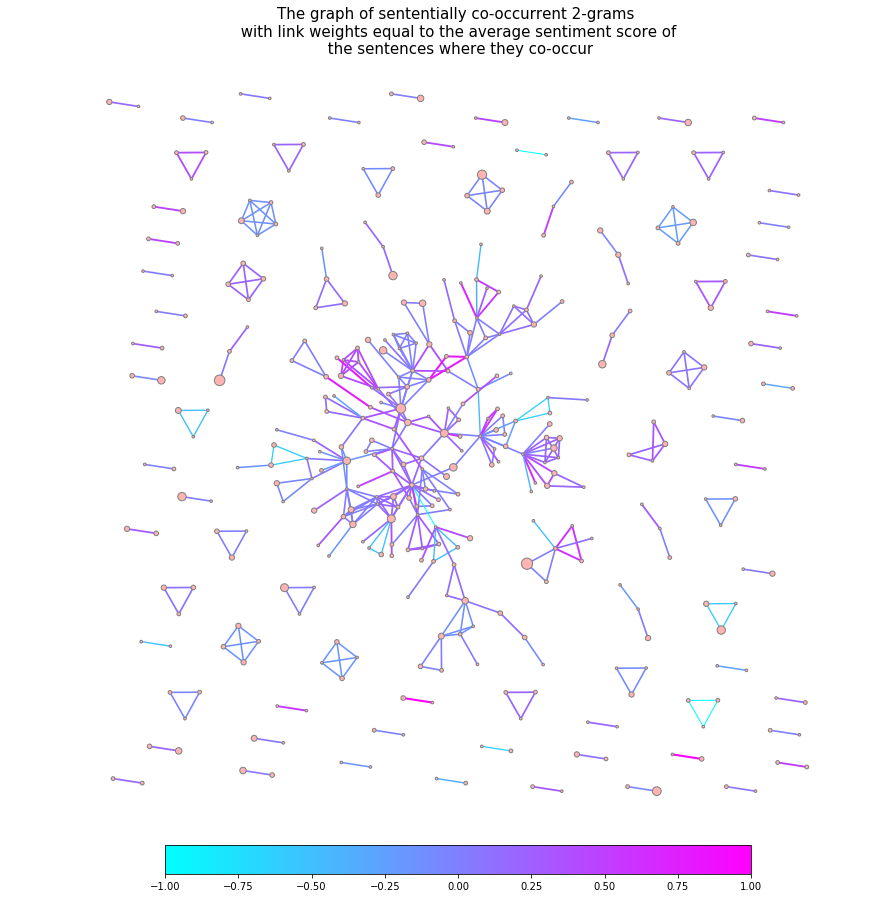

In [25]:
edge_width=[Gw[u][v]['weight'] for u,v in Gw.edges()]
# elabels = nx.get_edge_attributes(Gw,'weight')
edge_width1=[10*(0.1+w) for w in edge_width] 
# print edge_width

figsize=(15,17)

cmap=plt.cm.cool
weight_list = [ e[2]['weight'] for e in Gw.edges(data=True) ]
edge_color=weight_list
vmin = min(edge_color) 
vmax = max(edge_color) 
# width_list=[2*math.log(2+w) for w in weight_list]
width_list=[1.5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list

pos=graphviz_layout(Gw) 
node_color="#ffb3b3"
node_border_color="grey"
# edge_color="#668cff"

d = Gw.degree()
node_size=[7*v[1] for v in list(nx.degree(G))]

plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gw, pos,node_color=node_color,node_size=node_size)
nodes.set_edgecolor(node_border_color)
# nx.draw_networkx_edges(G, pos, edge_color=edge_color,width=edge_width,a=1)
nx.draw_networkx_edges(Gw, pos,width=width_list,edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,alpha=1)
labels_no={}
for n in G.nodes():
    labels_no[n]=''
nx.draw_networkx_labels(G, pos,labels=labels_no)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels);
plt.axis('off');
# yoffset = {}
# y_off = -15   # offset on the y axis
# for k, v in pos.items():
#     yoffset[k] = (v[0], v[1]+y_off)
# nx.draw_networkx_labels(Gw, yoffset,font_size=8);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
sst="The graph of sententially co-occurrent 2-grams \n with link weights equal to the average sentiment score of \n the sentences where they co-occur" 
plt.title(sst,fontsize=15);
plt.margins(x=0.1, y=0.05) 

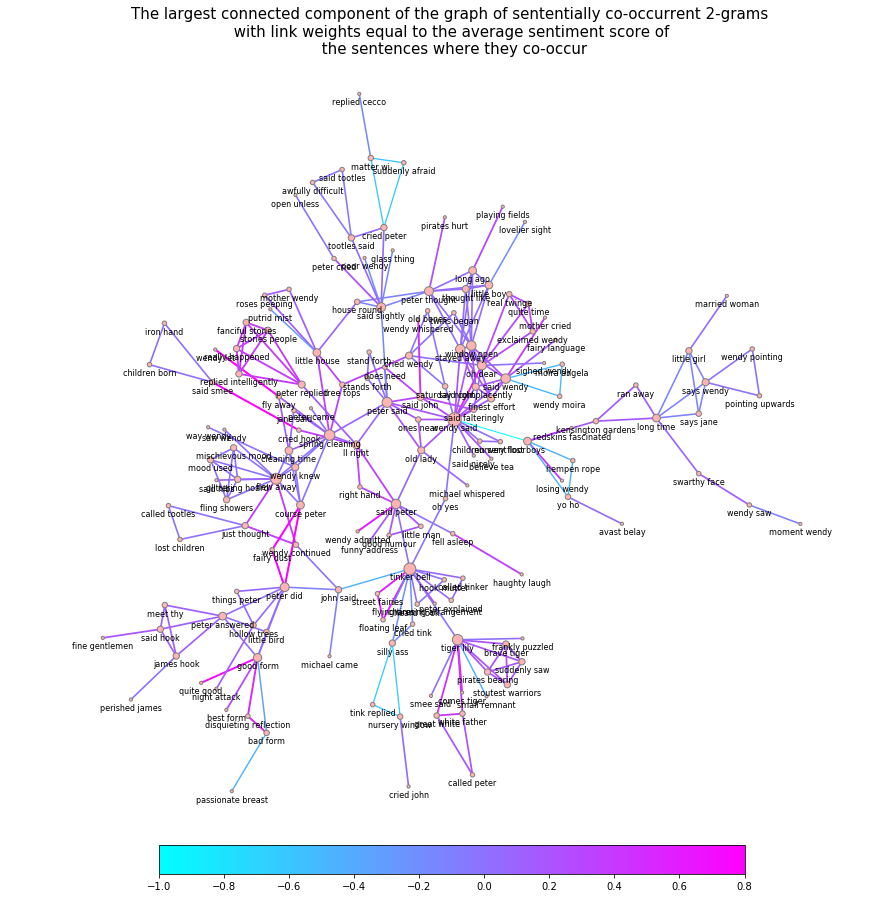

In [26]:
figsize=(15,17)

cmap=plt.cm.cool
weight_list = [ e[2]['weight'] for e in Gwlcc.edges(data=True) ]

edge_color=weight_list
vmin = min(edge_color) 
vmax = max(edge_color) 
width_list=[1.5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list

pos=graphviz_layout(Gwlcc) 
node_color="#ffb3b3"
node_border_color="grey"
# edge_color="#668cff"

d = Gwlcc.degree()
node_size=[10*v[1] for v in list(nx.degree(Gwlcc))]

plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gwlcc, pos,node_color=node_color,node_size=node_size)
nodes.set_edgecolor(node_border_color)
# nx.draw_networkx_edges(G, pos, edge_color=edge_color,width=edge_width,a=1)
nx.draw_networkx_edges(Gwlcc, pos,width=width_list,edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,alpha=1)
# nx.draw_networkx_labels(G, pos)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels);
plt.axis('off');
yoffset = {}
y_off = -10   # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(Gwlcc, yoffset,font_size=8);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
sst="The largest connected component of the graph of sententially co-occurrent 2-grams \n with link weights equal to the average sentiment score of \n the sentences where they co-occur" 
plt.title(sst,fontsize=15);
plt.margins(x=0.1, y=0.05) 